In [3]:
import os 
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import powerlaw

random.seed(133)
np.random.seed(133)

def weighted_average(history, decay=0.8):
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)

def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]


class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)

class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos
    def step(self): pass
    def advance(self): pass

class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, k=4, beta=0.1, delta=0.5, c=0.3, kappa=0.05,
                 epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                 logit=False, lambda_param=1.0, seed=133, activation='random', decay=0.8):
        super().__init__()

        # Store model parameters first so they're available to agents
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.num_agents, self.grid_size, self.num_bins = N, L, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay

        # Network and grid
        self.G = nx.watts_strogatz_graph(n=N, k=k, p=beta, seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.grid = MultiGrid(width=L, height=L, torus=False)
        self.schedule = SimultaneousActivation(self)

        # Create bins
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in [2, 5, 8] for y in [2, 5, 8]]
        for m, (x_m, y_m) in enumerate(bin_positions):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # Assign household coordinates
        coords = [(i, j) for i in range(L) for j in range(L)][:N]
        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0

        # Create households
        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)

        # Initialize social info
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        # Data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)

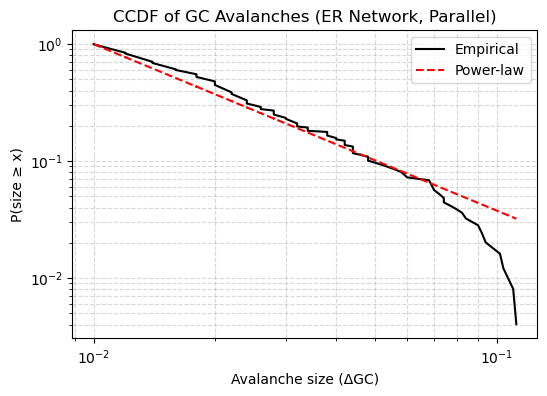

({'alpha': 2.4232309603085493,
  'xmin': 0.01,
  'ks': 0.119219534915534,
  'R_ln': -3.337236353111802,
  'p_ln': 0.10591311990778847,
  'R_exp': 13.430158563390176,
  'p_exp': 0.09052006783286282},
 [0.013999999999999999,
  0.05,
  0.020000000000000004,
  0.05399999999999999,
  0.07,
  0.043999999999999984,
  0.016000000000000014,
  0.019999999999999962,
  0.01200000000000001,
  0.043999999999999984,
  0.014000000000000012,
  0.04199999999999998,
  0.01200000000000001,
  0.02200000000000002,
  0.010000000000000009,
  0.020000000000000018,
  0.01200000000000001,
  0.014000000000000012,
  0.01200000000000001,
  0.01200000000000001])

In [4]:
# Re-import necessary modules due to environment reset
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
from joblib import Parallel, delayed
import os

# Parameters
N = 500
num_trials = 10
p_vals = np.linspace(0.0005, 0.005, 200)


# Function to compute giant component series for one trial
def compute_gc_series_trial(N, p_vals, seed=None):
    rng = np.random.default_rng(seed)
    gc_series = []
    for p in p_vals:
        G = nx.erdos_renyi_graph(N, p, seed=int(seed) % (2**32))

        if len(G) == 0 or not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1:
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# Run trials in parallel
all_gc_series = Parallel(n_jobs=-1)(
    delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
)

# Aggregate and compute avalanches
all_avalanches = []
for series in all_gc_series:
    aval = np.diff(series)
    aval = aval[aval > 0.01]
    all_avalanches.extend(aval)

# Fit power law
results = {}
if len(all_avalanches) >= 5:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01, discrete=False)

    results = {
        "alpha": fit.power_law.alpha,
        "xmin": fit.power_law.xmin,
        "ks": fit.power_law.KS(),
        "R_ln": fit.distribution_compare('power_law', 'lognormal')[0],
        "p_ln": fit.distribution_compare('power_law', 'lognormal')[1],
        "R_exp": fit.distribution_compare('power_law', 'exponential')[0],
        "p_exp": fit.distribution_compare('power_law', 'exponential')[1],
    }

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    plt.xlabel("Avalanche size (ΔGC)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF of GC Avalanches (ER Network, Parallel)")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/er_gc_avalanches_powerlaw_parallel.png", dpi=300)
    plt.show()

results, all_avalanches[:20]  # return preview of avalanches


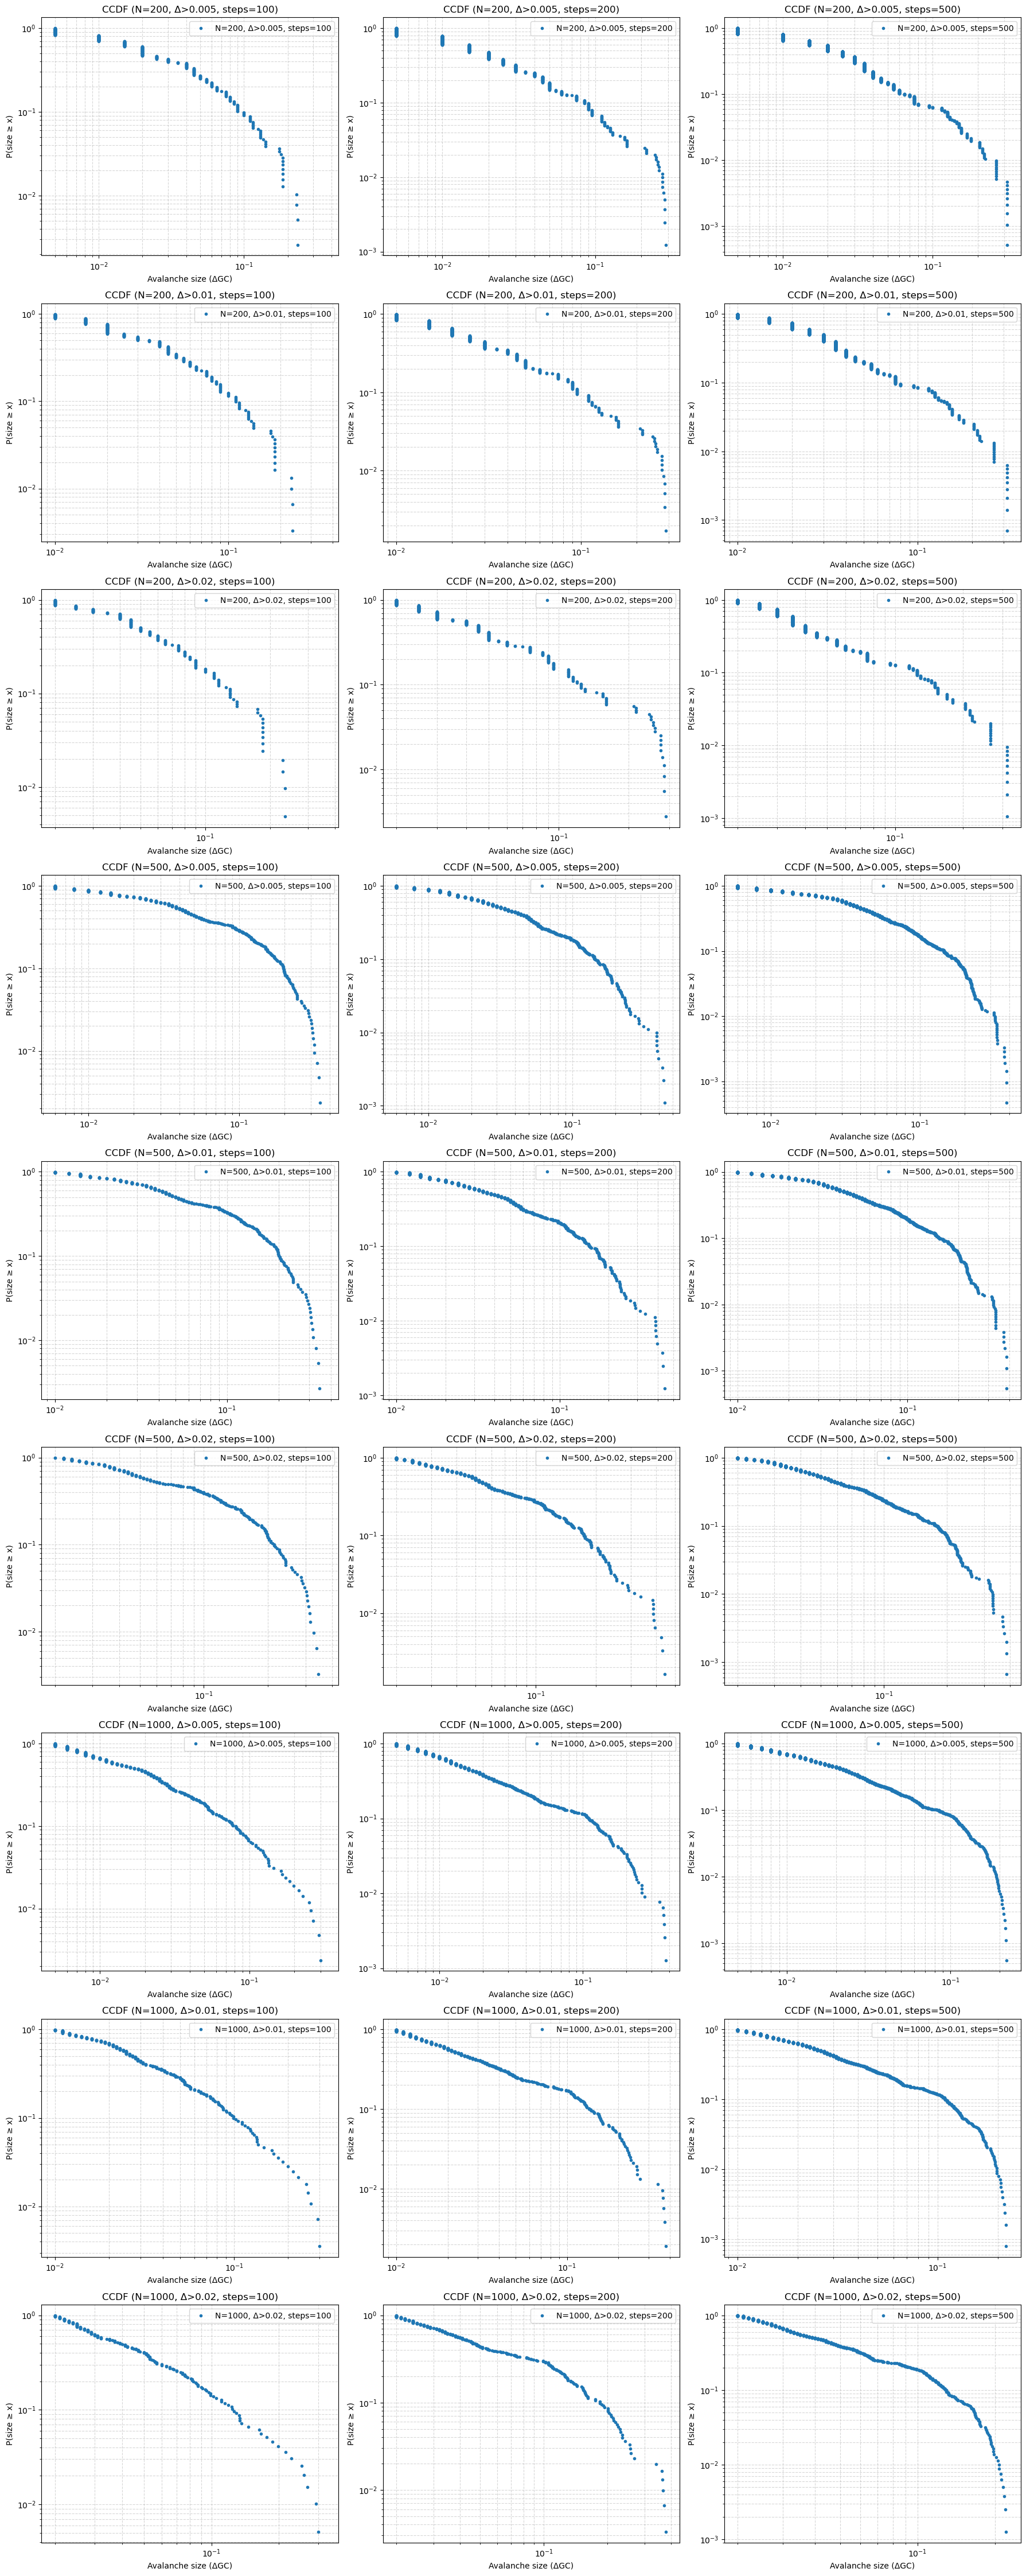

In [20]:
# Re-run after environment reset
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
import math
import itertools

# Setup
os.makedirs("figures", exist_ok=True)
Ns = [200, 500, 1000]
deltas = [0.005, 0.01, 0.02]
p_granularities = [100, 200, 500]
num_trials = 10
p_range = (0.0005, 0.005)

# Function to compute GC time series
def compute_gc_series_trial(N, p_vals, seed):
    gc_series = []
    for i, p in enumerate(p_vals):
        G = nx.erdos_renyi_graph(N, p, seed=seed + i)
        if len(G) == 0 or (not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1):
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# Compute avalanche sizes
def run_er_experiment(N, delta, p_steps):
    p_vals = np.linspace(*p_range, p_steps)
    all_gc_series = Parallel(n_jobs=-1)(
        delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
    )

    all_avalanches = []
    for series in all_gc_series:
        aval = np.diff(series)
        aval = aval[aval > delta]
        all_avalanches.extend(aval)
    
    return all_avalanches

# CCDF plot function
def plot_ccdf(data, ax, label):
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax.plot(sorted_data, ccdf, marker='.', linestyle='none', label=label)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Avalanche size (ΔGC)")
    ax.set_ylabel("P(size ≥ x)")
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.legend()

# Prepare parameter combinations
param_combinations = list(itertools.product(Ns, deltas, p_granularities))
n_plots = len(param_combinations)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()

# Run and plot
for i, (N, delta, p_steps) in enumerate(param_combinations):
    avalanches = run_er_experiment(N, delta=delta, p_steps=p_steps)
    ax = axs[i]
    label = f"N={N}, Δ>{delta}, steps={p_steps}"
    plot_ccdf(avalanches, ax, label=label)
    ax.set_title(f"CCDF (N={N}, Δ>{delta}, steps={p_steps})")

# Remove unused axes
for j in range(len(param_combinations), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("figures/er_avalanches_ccdf_all.png", dpi=300)
plt.show()


In [21]:
# Re-run everything after reset to compute KS statistics
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
import math
import itertools
import scipy.stats as stats
import pandas as pd

# Setup
os.makedirs("figures", exist_ok=True)
Ns = [200, 500, 1000]
deltas = [0.005, 0.01, 0.02]
p_granularities = [100, 200, 500]
num_trials = 10
p_range = (0.0005, 0.005)

# Function to compute GC time series
def compute_gc_series_trial(N, p_vals, seed):
    gc_series = []
    for i, p in enumerate(p_vals):
        G = nx.erdos_renyi_graph(N, p, seed=seed + i)
        if len(G) == 0 or (not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1):
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# Compute avalanche sizes
def run_er_experiment(N, delta, p_steps):
    p_vals = np.linspace(*p_range, p_steps)
    all_gc_series = Parallel(n_jobs=-1)(
        delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
    )

    all_avalanches = []
    for series in all_gc_series:
        aval = np.diff(series)
        aval = aval[aval > delta]
        all_avalanches.extend(aval)
    
    return all_avalanches

# Function to compute KS statistic (empirical CCDF vs fitted power-law)
def compute_ks_statistic(data):
    sorted_data = np.sort(data)
    ccdf_empirical = 1.0 - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    xmin = sorted_data[0]
    alpha = 1 + len(sorted_data) / np.sum(np.log(sorted_data / xmin))
    ccdf_theoretical = (sorted_data / xmin) ** (-alpha + 1)
    ccdf_theoretical /= ccdf_theoretical[0]
    ks_stat = np.max(np.abs(ccdf_empirical - ccdf_theoretical))
    return ks_stat, alpha

# Compute KS stats for all combinations
param_combinations = list(itertools.product(Ns, deltas, p_granularities))
ks_results = []

for (N, delta, p_steps) in param_combinations:
    avalanches = run_er_experiment(N, delta=delta, p_steps=p_steps)
    if len(avalanches) > 5:
        ks, alpha_est = compute_ks_statistic(np.array(avalanches))
        ks_results.append((N, delta, p_steps, ks, alpha_est))

# Present results
ks_df = pd.DataFrame(ks_results, columns=["N", "Delta", "p_steps", "KS_stat", "Alpha_est"])
print(ks_df)


       N  Delta  p_steps   KS_stat  Alpha_est
0    200  0.005      100  0.204763   1.645374
1    200  0.005      200  0.211372   1.764677
2    200  0.005      500  0.211295   1.735003
3    200  0.010      100  0.192227   1.802262
4    200  0.010      200  0.169521   1.948460
5    200  0.010      500  0.219877   1.927081
6    200  0.020      100  0.220077   2.028946
7    200  0.020      200  0.136490   2.165437
8    200  0.020      500  0.165373   2.316148
9    500  0.005      100  0.206325   1.506081
10   500  0.005      200  0.201951   1.571385
11   500  0.005      500  0.213884   1.563021
12   500  0.010      100  0.204062   1.580651
13   500  0.010      200  0.163066   1.697432
14   500  0.010      500  0.219923   1.660258
15   500  0.020      100  0.167693   1.762450
16   500  0.020      200  0.134881   1.923479
17   500  0.020      500  0.162884   1.917963
18  1000  0.005      100  0.114949   1.752708
19  1000  0.005      200  0.091328   1.762060
20  1000  0.005      500  0.122220

Assuming nested distributions


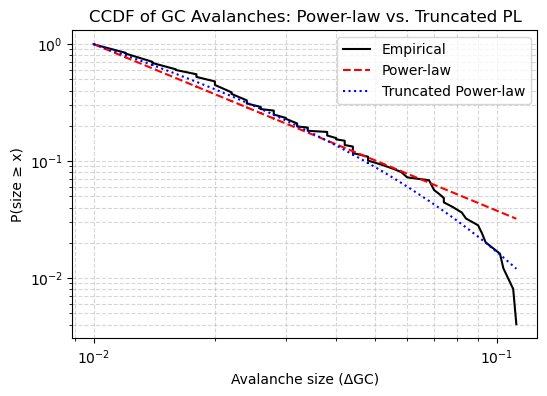

Results:
 {'alpha': 2.4232309603085493, 'xmin': 0.01, 'ks': 0.119219534915534, 'R_ln': -3.337236353111802, 'p_ln': 0.10591311990778847, 'R_exp': 13.430158563390176, 'p_exp': 0.09052006783286282, 'R_tpl': -5.231109181362753, 'p_tpl': 0.0012184087424454981, 'lambda_tpl': 14.95665836674133}


In [5]:
import powerlaw
import matplotlib.pyplot as plt
import os

# Fit power law (requires at least 5 data points)
if len(all_avalanches) >= 5:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01, discrete=False, verbose=False)

    # Fit comparisons
    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    R_tpl, p_tpl = fit.distribution_compare('power_law', 'truncated_power_law')

    # Extract parameters
    results = {
        'alpha': fit.power_law.alpha,
        'xmin': fit.power_law.xmin,
        'ks': fit.power_law.KS(),
        'R_ln': R_ln,
        'p_ln': p_ln,
        'R_exp': R_exp,
        'p_exp': p_exp,
        'R_tpl': R_tpl,
        'p_tpl': p_tpl,
        'lambda_tpl': fit.truncated_power_law.parameter2,
    }

    # Plot CCDF
    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    fit.truncated_power_law.plot_ccdf(ax=ax, color='blue', linestyle=':', label='Truncated Power-law')
    plt.xlabel("Avalanche size (ΔGC)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF of GC Avalanches: Power-law vs. Truncated PL")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/er_gc_truncated_powerlaw_comparison.png", dpi=300)
    plt.show()

    print("Results:\n", results)
else:
    print("Not enough avalanche data to fit.")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import os

def check_powerlaw_fit(data, delta=0.01, seed=42, savefig=True, fig_prefix="figures/powerlaw_check"):
    # Filter avalanche data
    data = np.array(data)
    data = data[data > delta]

    if len(data) < 5:
        print("Not enough avalanche data to fit.")
        return None

    print(f"Fitting power law to {len(data)} data points...")

    # Fit power law
    fit = powerlaw.Fit(data, xmin=delta, discrete=False, verbose=False)

    # Compare distributions
    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    R_tpl, p_tpl = fit.distribution_compare('power_law', 'truncated_power_law')

    # KS statistic only
    ks_stat = fit.power_law.KS()

    # Extract results
    results = {
        'alpha': fit.power_law.alpha,
        'xmin': fit.power_law.xmin,
        'ks': ks_stat,
        'R_ln': R_ln, 'p_ln': p_ln,
        'R_exp': R_exp, 'p_exp': p_exp,
        'R_tpl': R_tpl, 'p_tpl': p_tpl,
        'lambda_tpl': fit.truncated_power_law.parameter2,
    }

    print("\nFitting Summary:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Plot CCDF
    fig_ccdf, ax_ccdf = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax_ccdf, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax_ccdf, color='red', linestyle='--', label='Power-law')
    fit.truncated_power_law.plot_ccdf(ax=ax_ccdf, color='blue', linestyle=':', label='Truncated Power-law')
    ax_ccdf.set_xlabel("Avalanche size (ΔGC)")
    ax_ccdf.set_ylabel("P(size ≥ x)")
    ax_ccdf.set_title("CCDF of GC Avalanches")
    ax_ccdf.grid(True, which='both', linestyle='--', alpha=0.5)
    ax_ccdf.legend()
    if savefig:
        os.makedirs(os.path.dirname(fig_prefix), exist_ok=True)
        fig_ccdf.savefig(f"{fig_prefix}_ccdf.png", dpi=300)
    plt.show()

    # Plot PDF
    fig_pdf, ax_pdf = plt.subplots(figsize=(6, 4))
    fit.plot_pdf(ax=ax_pdf, color='black', label='Empirical')
    fit.power_law.plot_pdf(ax=ax_pdf, color='red', linestyle='--', label='Power-law')
    fit.truncated_power_law.plot_pdf(ax=ax_pdf, color='blue', linestyle=':', label='Truncated Power-law')
    ax_pdf.set_xlabel("Avalanche size (ΔGC)")
    ax_pdf.set_ylabel("p(x)")
    ax_pdf.set_title("PDF of GC Avalanches")
    ax_pdf.legend()
    ax_pdf.grid(True, which='both', linestyle='--', alpha=0.5)
    if savefig:
        fig_pdf.savefig(f"{fig_prefix}_pdf.png", dpi=300)
    plt.show()

    # Manual KS + alpha sensitivity plot over xmin
    xmin_values = np.linspace(delta, np.percentile(data, 90), 20)
    alphas, ks_vals = [], []
    for xmin in xmin_values:
        try:
            test_fit = powerlaw.Fit(data, xmin=xmin, discrete=False, verbose=False)
            alphas.append(test_fit.power_law.alpha)
            ks_vals.append(test_fit.power_law.KS())
        except Exception:
            alphas.append(np.nan)
            ks_vals.append(np.nan)

    # Plot sensitivity
    plt.figure(figsize=(6, 4))
    plt.plot(xmin_values, ks_vals, label='KS')
    plt.plot(xmin_values, alphas, label='Alpha')
    plt.xlabel("xmin")
    plt.title("Sensitivity of Alpha and KS to xmin")
    plt.legend()
    plt.grid(True)
    if savefig:
        plt.savefig(f"{fig_prefix}_alpha_ks_vs_xmin.png", dpi=300)
    plt.show()

    return results


Fitting power law to 248 data points...

Fitting Summary:
alpha: 2.4232
xmin: 0.0100
ks: 0.1192
R_ln: -3.3372
p_ln: 0.1059
R_exp: 13.4302
p_exp: 0.0905
R_tpl: -5.2311
p_tpl: 0.0012
lambda_tpl: 14.9567


Assuming nested distributions


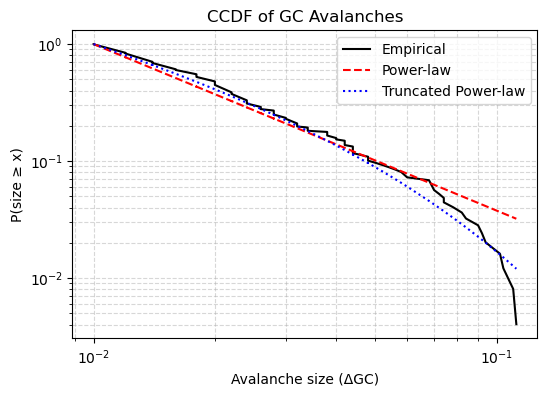

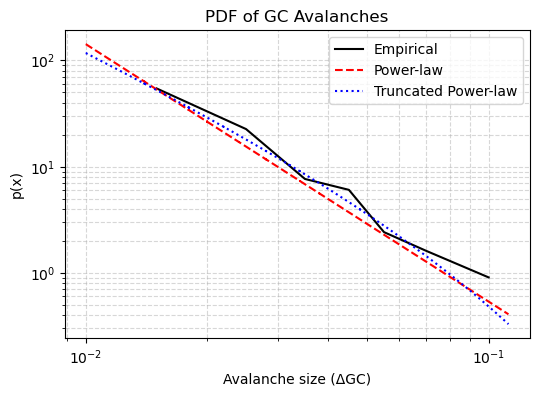

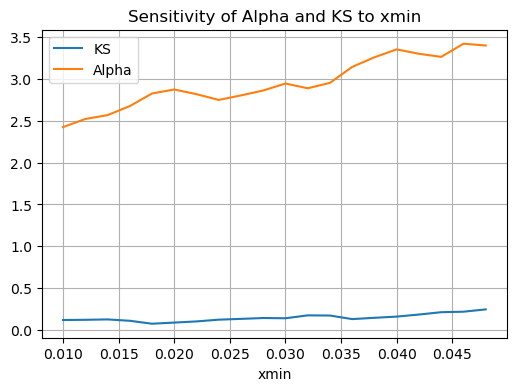

In [11]:
# Example use
results = check_powerlaw_fit(all_avalanches, delta=0.01)
